In [1]:
from sklearn import preprocessing
import numpy as np
from keras.datasets import mnist
from keras.models import Model, load_model
from keras.layers import Dense, Reshape, Flatten, Activation, Input, Concatenate
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.concatenate((x_train, x_test), axis=0)
y_train = np.concatenate((y_train, y_test), axis=0)

prep = preprocessing.MinMaxScaler(feature_range=(-1, 1))
X_temp = prep.fit_transform(x_train.reshape((x_train.shape[0], -1)))
X_train = X_temp.reshape((X_temp.shape[0], 28, 28, 1))


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
MyOptimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

In [4]:
def Generator(input_layer, condition):
    hid = Concatenate()([input_layer, condition])
    
    hid = Dense(8 * 14 * 14)(hid)    
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)
    hid = Reshape((14, 14, 8))(hid)

    hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)    
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(1, kernel_size=5, strides=1, padding="same")(hid)
    out = Activation("tanh")(hid)

    model = Model(inputs=[input_layer, condition], outputs=out)

    return model, out


In [5]:
input_layer = Input(shape=(10,))
dis_condition_input = Input(shape=(10,))
generator, gen_out = Generator(input_layer, dis_condition_input)
generator.compile(loss='categorical_crossentropy', optimizer=MyOptimizer)

# generator.summary()

In [6]:
def Discriminator(input_layer, condition):
    hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)
    hid = Flatten()(hid)
    hid = Dense(20, activation='relu')(hid)

    merged_layer = Concatenate()([hid, condition])
    out = Dense(20, activation='softmax')(merged_layer)
    mdl = Model(inputs=[input_layer, condition], outputs=out)

    return mdl, out

In [7]:
dis_img_input = Input(shape=(28,28,1))
dis_condition_input = Input(shape=(10,))
discriminator, disc_out = Discriminator(dis_img_input, dis_condition_input)
discriminator.compile(optimizer=MyOptimizer, loss='categorical_crossentropy')
# discriminator.summary()

In [8]:
def GenDis(gen, dis, condition_input):
    dis.trainable = False
    
    gan_input = Input(shape=(10,))
    x = gen([gan_input, condition_input])
    gan_out = dis([x, condition_input])
    gan = Model(inputs=[gan_input, condition_input], output=gan_out)
    
    return gan, gan_out

In [9]:
condition_input = Input(shape=(10,))
gendis, gan_out = GenDis(generator, discriminator, condition_input)
gendis.compile(loss='categorical_crossentropy', optimizer=MyOptimizer)

# gendis.summary()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("mo..., inputs=[<tf.Tenso...)`
  import sys


In [10]:
epochs = 1000
batch_size = 64

d_loss = 0
g_loss = 0
for epoch in range(epochs):
    
    # train discriminator
    random_index = np.random.randint(0, X_train.shape[0], batch_size)
    legit_images = X_train[random_index]
    d_loss += discriminator.train_on_batch([legit_images, to_categorical(y=y_train[random_index],num_classes=10)],
                                           to_categorical(y=y_train[random_index],num_classes=20))
    

    random_index = np.random.randint(0, X_train.shape[0], batch_size)
    gen_noise = np.random.normal(0, 1, (random_index.shape[0], 10))
    syntetic_images = generator.predict([gen_noise, to_categorical(y=y_train[random_index],num_classes=10)])
    d_loss += discriminator.train_on_batch([syntetic_images, to_categorical(y=y_train[random_index],num_classes=10)], 
                                           to_categorical(y=y_train[random_index]+10,num_classes=20))


    # train generator
    for i in range(2):
        random_index = np.random.randint(0, X_train.shape[0], batch_size)
        gen_noise = np.random.normal(0, 1, (random_index.shape[0], 10))
        g_loss += gendis.train_on_batch([gen_noise, to_categorical(y=y_train[random_index],num_classes=10)],
                                        to_categorical(y=y_train[random_index], num_classes=20))

    if epoch % 10 == 0:
        print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (epoch, d_loss/20, g_loss/20))
        d_loss = 0
        g_loss = 0

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.324576], [ Generator :: loss: 0.315276]
epoch: 10, [Discriminator :: d_loss: 2.167894], [ Generator :: loss: 3.347081]
epoch: 20, [Discriminator :: d_loss: 1.390174], [ Generator :: loss: 2.994824]
epoch: 30, [Discriminator :: d_loss: 1.237680], [ Generator :: loss: 2.372499]
epoch: 40, [Discriminator :: d_loss: 1.044398], [ Generator :: loss: 2.270550]
epoch: 50, [Discriminator :: d_loss: 0.850779], [ Generator :: loss: 2.206763]
epoch: 60, [Discriminator :: d_loss: 0.844986], [ Generator :: loss: 2.424000]
epoch: 70, [Discriminator :: d_loss: 0.766514], [ Generator :: loss: 2.385318]
epoch: 80, [Discriminator :: d_loss: 0.758683], [ Generator :: loss: 2.269325]
epoch: 90, [Discriminator :: d_loss: 0.782993], [ Generator :: loss: 2.313859]
epoch: 100, [Discriminator :: d_loss: 0.779236], [ Generator :: loss: 2.246524]
epoch: 110, [Discriminator :: d_loss: 0.726200], [ Generator :: loss: 2.132641]
epoch: 120, [Discriminator :: d_loss: 0.700680], [ 

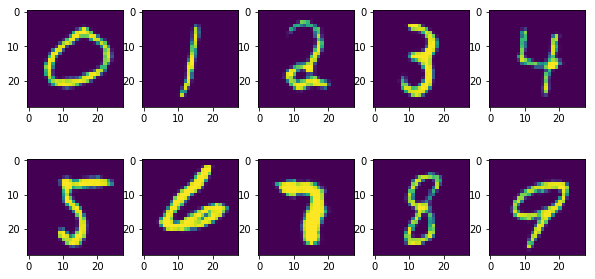

In [20]:
control = np.arange(10)
gen_noise = np.random.normal(0, 1, (control.shape[0], 10))
pr = generator.predict([gen_noise, to_categorical(y=control, num_classes=10)])
random_index

plt.figure(figsize=(10, 5))


for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(pr[i, :, :, 0])
plt.savefig('digits.png')

In [12]:
generator.save('generator.h5')